In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import holidays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer #agregado
from sklearn.pipeline import Pipeline #agregado

In [5]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [6]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [7]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


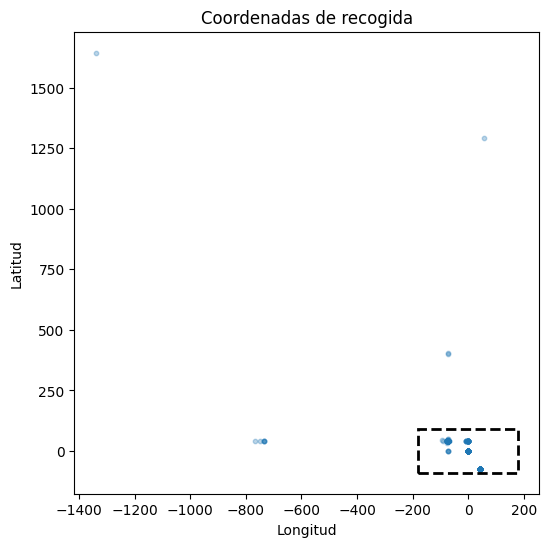

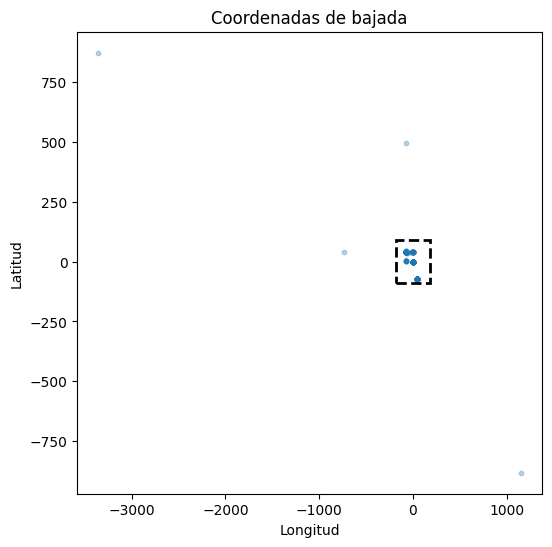

In [9]:
#Coordenadas de Pickup
plt.figure(figsize=(6,6))
plt.scatter(df["pickup_longitude"], df["pickup_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida")
plt.show()

#Coordenadas de Dropoff
plt.figure(figsize=(6,6))
plt.scatter(df["dropoff_longitude"], df["dropoff_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de bajada")
plt.show()


***JUSTIFICACION DE POR QUE DROPEAMOS COORDENADAS INVALIDAS***

Primero validamos las coordenadas para evitar que valores inválidos generen distancias absurdas. Incluso dentro del rango [-90,90]/[-180,180]

In [10]:
#Coordenadas reales
lat_min, lat_max = -90, 90  
lon_min, lon_max = -180, 180

valid_pickup_lat = df["pickup_latitude"].between(lat_min, lat_max)
valid_pickup_lon = df["pickup_longitude"].between(lon_min, lon_max)
valid_dropoff_lat = df["dropoff_latitude"].between(lat_min, lat_max)
valid_dropoff_lon = df["dropoff_longitude"].between(lon_min, lon_max)

invalid_counts = (
    (~valid_pickup_lat).astype(int) +
    (~valid_pickup_lon).astype(int) +
    (~valid_dropoff_lat).astype(int) +
    (~valid_dropoff_lon).astype(int)
)

#Dropeamos filas con más de 1 coordenada inválida
df_filtrado = df[invalid_counts <= 1]


#Reemplazamos las coordenadas inválidas con NaN
df_filtrado.loc[~valid_pickup_lat, "pickup_latitude"] = np.nan
df_filtrado.loc[~valid_pickup_lon, "pickup_longitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lat, "dropoff_latitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lon, "dropoff_longitude"] = np.nan
df_filtrado.isna().sum()



 

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     6
pickup_latitude      2
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Cantidad de valores negativos en fare_amount: 22
Porcentaje de valores negativos sobre el total de registros en fare_amount: 0.011000165002475037%


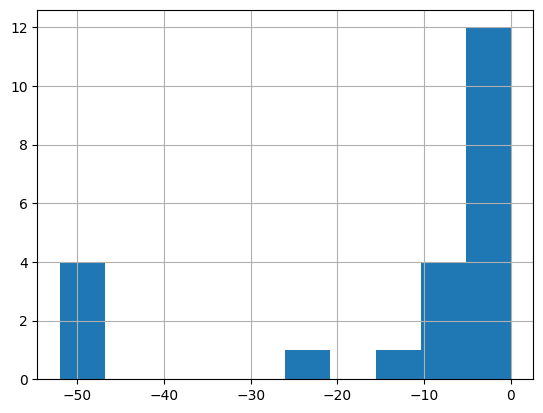

In [11]:
df_filtrado['fare_amount'].isnull().sum() #no hay nulos en fare_amount
df_filtrado[df_filtrado["fare_amount"] <= 0]["fare_amount"].hist()
negativos = df_filtrado[df_filtrado["fare_amount"] <= 0]['fare_amount'].size
print(f"Cantidad de valores negativos en fare_amount: {negativos}")
print(f"Porcentaje de valores negativos sobre el total de registros en fare_amount: {negativos / df_filtrado.fare_amount.size * 100}%")  # porcentaje de negativos en fare_amount
df_filtrado = df_filtrado[df_filtrado['fare_amount'] > 0]  # eliminamos los negativos y ceros


In [12]:
df_filtrado.shape

(199975, 9)

***AGREGAR JUSTIFICACION DE PORQUE BOLETEAMOS LOS NULOS***

<Axes: xlabel='distance_km'>

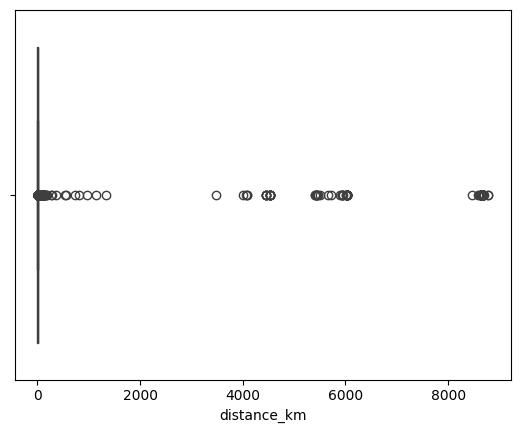

In [13]:
def haversine_km(lat1, lon1, lat2, lon2):
    # retorna distancia en kilómetros (vectorizado)
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


df_filtrado['distance_km'] = haversine_km(
    df_filtrado['pickup_latitude'], df_filtrado['pickup_longitude'],
    df_filtrado['dropoff_latitude'], df_filtrado['dropoff_longitude']
)

df_filtrado['distance_km'].describe()
sns.boxplot(x=df_filtrado['distance_km'])



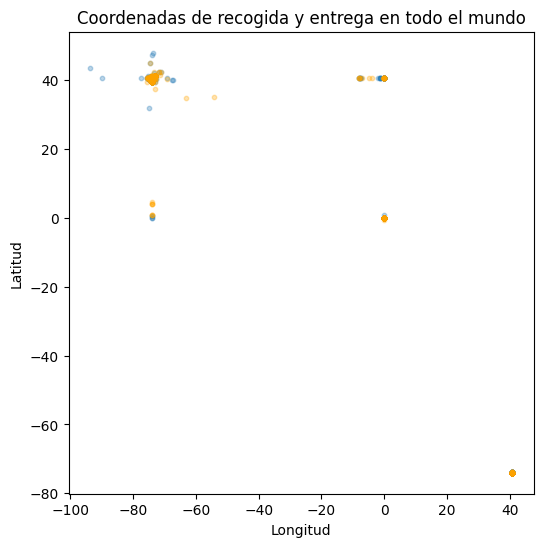

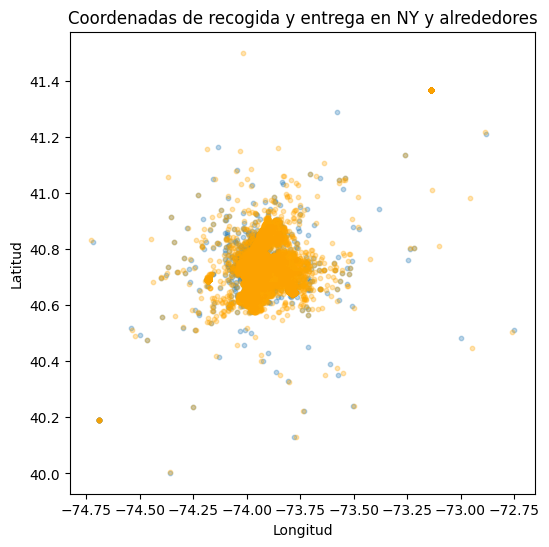

In [14]:
ny_coords = (
    (df_filtrado["pickup_latitude"].between(40, 42)| df_filtrado["pickup_latitude"].isna())&
    (df_filtrado["pickup_longitude"].between(-75, -72) | df_filtrado["pickup_longitude"].isna()) &
    (df_filtrado["dropoff_latitude"].between(40, 42) | df_filtrado["dropoff_latitude"].isna()) &
    (df_filtrado["dropoff_longitude"].between(-75, -72) | df_filtrado["dropoff_longitude"].isna())
)
df_filtrado_ny = df_filtrado[ny_coords].copy()
plt.figure(figsize=(6,6))
plt.scatter(df_filtrado["pickup_longitude"], df_filtrado["pickup_latitude"], s=10, alpha=0.3)
plt.scatter(df_filtrado["dropoff_longitude"], df_filtrado["dropoff_latitude"], s=10, alpha=0.3, color='orange')
plt.xlabel("Longitud")          
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida y entrega en todo el mundo")      
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_filtrado_ny["pickup_longitude"], df_filtrado_ny["pickup_latitude"], s=10, alpha=0.3)
plt.scatter(df_filtrado_ny["dropoff_longitude"], df_filtrado_ny["dropoff_latitude"], s=10, alpha=0.3, color='orange')
plt.xlabel("Longitud")          
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida y entrega en NY y alrededores")      
plt.show()

In [15]:
df_filtrado_ny["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce", utc=True)

df_filtrado_ny["pickup_datetime"] = df_filtrado_ny["pickup_datetime"].dt.tz_convert("America/New_York")

us_holidays = holidays.US(years=df_filtrado_ny["pickup_datetime"].dt.year.unique(), state="NY")

df_filtrado_ny["is_holiday"] = df_filtrado_ny["pickup_datetime"].dt.date.isin(us_holidays).astype(int)


df_filtrado_ny["is_workday"] = (
    (df_filtrado_ny["pickup_datetime"].dt.dayofweek < 4) &  # lunes a jueves
    (~df_filtrado_ny["pickup_datetime"].dt.date.astype('datetime64[ns]').isin(us_holidays))  # feriado o fin de semana
).astype(int)

df_filtrado_ny[[ "is_holiday", "is_workday"]].value_counts()

# Extraer hora
df_filtrado_ny["hora_recogida"] = df_filtrado_ny["pickup_datetime"].dt.hour

df_filtrado_ny["mañana"] = (
    df_filtrado_ny["hora_recogida"].between(6, 11)
).astype(int)

df_filtrado_ny["tarde"] = (
    df_filtrado_ny["hora_recogida"].between(12, 19)
).astype(int)   

df_filtrado_ny["noche"] = (
    df_filtrado_ny["hora_recogida"].between(20, 23)
).astype(int)


df_modelo = df_filtrado_ny.drop(columns=["key", "hora_recogida", "pickup_datetime", "date"])

df_modelo["is_holiday"].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\467827371.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  (~df_filtrado_ny["pickup_datetime"].dt.date.astype('datetime64[ns]').isin(us_holidays))  # feriado o fin de semana


is_holiday
0    190063
1      5734
Name: count, dtype: int64

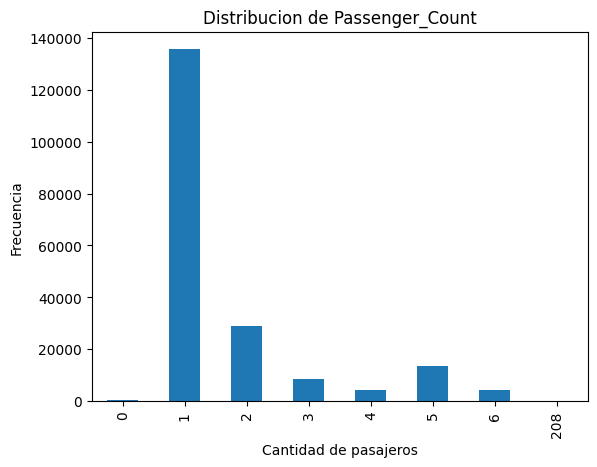

passenger_count
1      135491
2       28835
5       13722
3        8696
6        4184
4        4182
0         686
208         1
Name: count, dtype: int64

In [16]:
df_modelo["passenger_count"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribucion de Passenger_Count")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.show()
df_modelo["passenger_count"].value_counts()


In [17]:
### Creamos una nueva variable dummie con el tipo de viaje por pasajero 

df_modelo["uber_comun"] = df_modelo["passenger_count"].isin([1, 2, 3, 4]).astype(int)
df_modelo["uber_grande"] = df_modelo["passenger_count"].isin([5, 6]).astype(int)
#Convertimos el valor 208 en nulo 
df_modelo["passenger_count"] = df_modelo["passenger_count"].replace(208, np.nan)

LO DE ABAJO ESTA MAL SEGUN EL PROFE: ESTADISTICAS VAN DESPUES DEL SPLITIII
----

Cantidad de viajes con distancia = 0: 2038

Estadísticas de fare_amount en viajes con distancia = 0:
count    2038.000000
mean       11.101305
std        14.647066
min         2.500000
25%         4.900000
50%         6.500000
75%        10.100000
max       200.000000
Name: fare_amount, dtype: float64


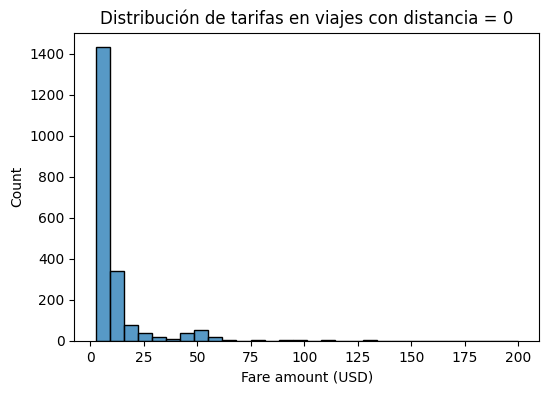

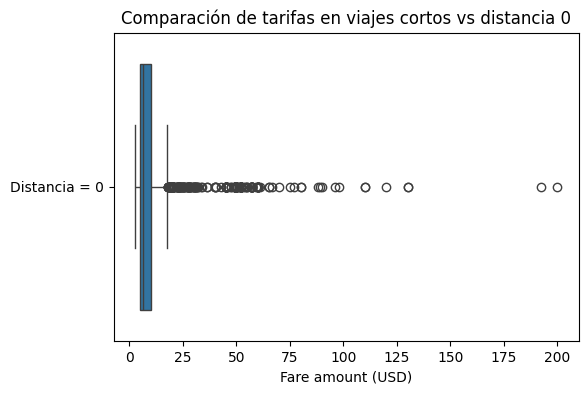

(1012,)

In [18]:
# 1. Contar cuántos viajes tienen distancia 0
zero_dist = df_modelo[df_modelo["distance_km"] == 0]
print("Cantidad de viajes con distancia = 0:", len(zero_dist))

# 2. Describir sus tarifas
print("\nEstadísticas de fare_amount en viajes con distancia = 0:")
print(zero_dist["fare_amount"].describe())

# 3. Histograma de esas tarifas
plt.figure(figsize=(6,4))
sns.histplot(zero_dist["fare_amount"], bins=30, kde=False)
plt.xlabel("Fare amount (USD)")
plt.title("Distribución de tarifas en viajes con distancia = 0")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(
    data=[zero_dist["fare_amount"]],
    orient="h"
)
plt.yticks([0], ["Distancia = 0"])
plt.xlabel("Fare amount (USD)")
plt.title("Comparación de tarifas en viajes cortos vs distancia 0")
plt.show()

zero_dist[zero_dist["fare_amount"] > 6.5]["fare_amount"].shape


De 2000 registros con distancia 0, graficamos y analizamos el target de cada uno, seleccionando como "precio base" hasta 6.5 USD, para tomar como válidos los viajes con distancia 0 y darle una mínima referencia al modelo. Quedaron dropeados 1012 y 925 dentro del dataset.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_modelo.drop(columns='fare_amount'), df_modelo['fare_amount'], test_size=0.2, random_state=42)


IMPUTACION DE VALORES FALTANTES EN COORDENADAS Y DISTANCIAS 
--------------------------------------------------------------

In [69]:
coords = ["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]

invalidas = X_train[coords].isna().sum(axis=1)
filas_a_imputar = X_train[invalidas == 1].copy()


scaler = StandardScaler()
X_escaladas_train = scaler.fit_transform(filas_a_imputar[coords])

# 3️⃣ Imputación KNN en X_train
imputer = KNNImputer(n_neighbors=5)
X_imputadas_train = imputer.fit_transform(X_escaladas_train)

# 4️⃣ Volvemos a coordenadas originales en X_train
filas_a_imputar[coords] = scaler.inverse_transform(X_imputadas_train)

# 5️⃣ Reintegrar al X_train original
X_train.update(filas_a_imputar)

# 6️⃣ Imputación en X_test usando los mismos scaler e imputador
invalidas_test = X_test[coords].isna().sum(axis=1)
filas_a_imputar_test = X_test[invalidas_test == 1].copy()

# Escalar X_test con scaler ya ajustado
X_escaladas_test = scaler.transform(filas_a_imputar_test[coords])

# Imputar usando imputador ya ajustado
X_imputadas_test = imputer.transform(X_escaladas_test )

# Volvemos a coordenadas originales en X_test
filas_a_imputar_test[coords] = scaler.inverse_transform(X_imputadas_test)

# Reintegrar al X_test original
X_test.update(filas_a_imputar_test)



C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario

In [70]:
X_train['distance_km'] = haversine_km(
    X_train['pickup_latitude'], X_train['pickup_longitude'],
    X_train['dropoff_latitude'], X_train['dropoff_longitude']
)

X_test['distance_km'] = haversine_km(
    X_test['pickup_latitude'], X_test['pickup_longitude'],
    X_test['dropoff_latitude'], X_test['dropoff_longitude']
)

IMPUTACION DE LOS VALORES DE FARE_AMOUNT DE LA DISTANCIA 0


In [71]:
### IMPUTAMOS PASAJEROS POR LA MODA
# Encontrar la moda en el conjunto de entrenamiento
zero_dist_train = y_train[X_train["distance_km"] < 0.1]
# Encontrar la moda solo en train
moda_fare_train = zero_dist_train.mode()[0]
# Imputar en train y test usando la misma moda
y_train.loc[X_train["distance_km"] < 0.1] = moda_fare_train
y_test.loc[X_test["distance_km"] < 0.1] = moda_fare_train





IMPUTACION DE PASAJEROS POR LA MODA
-----------------------------------

In [72]:
##imputamos valor nulo de passenger_count por la moda
moda_passenger = X_train["passenger_count"].mode()[0]
X_train["passenger_count"].fillna(moda_passenger, inplace=True)
X_test["passenger_count"].fillna(moda_passenger, inplace=True)  


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\3257366643.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["passenger_count"].fillna(moda_passenger, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15788\3257366643.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

pickup_longitude    -73.968377
pickup_latitude      40.764602
dropoff_longitude   -73.968368
dropoff_latitude     40.764600
passenger_count       1.000000
distance_km           0.000790
is_holiday            0.000000
is_workday            0.000000
mañana                0.000000
tarde                 0.000000
noche                 0.000000
uber_comun            1.000000
uber_grande           0.000000
Name: 170081, dtype: float64

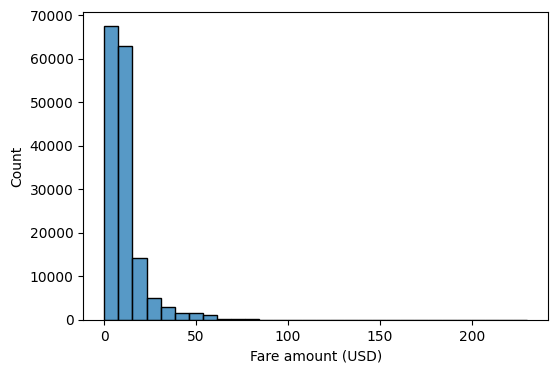

In [73]:
##histograma de fare_amount
plt.figure(figsize=(6,4))   
sns.histplot(y_train, bins=30, kde=False)
plt.xlabel("Fare amount (USD)")
##fare_amount mayores a 200
y_train[y_train > 200]
##ver fila del indice 170081
X_train.loc[170081]



In [74]:
#imputar coordenadas con knn

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Entrenamos el pipeline con training set
pipe_lr.fit(X_train, y_train)

# Predicciones sobre train y test
y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)

print("Entrenamiento:")
### RMSE calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_train, y_train_pred))

print("\nPrueba:")
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_test_pred))

Entrenamiento:
RMSE: 4.7397528590642795
R²: 0.7495353686990965

Prueba:
RMSE: 4.590756297324756
R²: 0.7716887597108852


***AGREGAR JUSTIFICACION DE QUE VAMOS A HACER CON EL OUTLIER***
No eliminamos filas innecesariamente y no inventamos datos arbitrarios. Usamos la moda porque refleja el valor más frecuente y es consistente con la realidad del dominio (viajes de 1 pasajero).